# 基于物品的协同过滤推荐

In [1]:
# 导入包
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 一. 通用函数定义

In [2]:
# 定义装饰器，监控运行时间
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print('Func %s, run time: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

### 1. 数据处理相关
1. load data
2. split data

In [3]:
class Dataset():
    
    def __init__(self, fp):
        # fp: data file path
        self.data = self.loadData(fp)
    
    def loadData(self, fp):
        data = []
        for l in open(fp):
            data.append(tuple(map(int, l.strip().split('::')[:2])))
        return data
    
    def splitData(self, M, k, seed=1):
        '''
        :params: data, 加载的所有(user, item)数据条目
        :params: M, 划分的数目,最后需要取M折的平均
        :params: k, 本次是第几次划分,k~[0, M)
        :params: seed, random的种子数,对于不同的k应设置成一样的
        :return: train, test
        '''
        train, test = [], []
        random.seed(seed)
        for user, item in self.data:
            # 这里与书中的不一致，本人认为取M-1较为合理，因randint是左右都覆盖的
            if random.randint(0, M-1) == k:  
                test.append((user, item))
            else:
                train.append((user, item))

        # 处理成字典的形式，user->set(items)
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                if user not in data_dict:
                    data_dict[user] = set()
                data_dict[user].add(item)
            data_dict = {k: list(data_dict[k]) for k in data_dict}
            return data_dict

        return convert_dict(train), convert_dict(test)

### 2. 评价指标
1. Precision
2. Recall
3. Coverage
4. Popularity(Novelty)

In [4]:
class Metric():
    
    def __init__(self, train, test, GetRecommendation):
        '''
        :params: train, 训练数据
        :params: test, 测试数据
        :params: GetRecommendation, 为某个用户获取推荐物品的接口函数
        '''
        self.train = train
        self.test = test
        self.GetRecommendation = GetRecommendation
        self.recs = self.getRec()
        
    # 为test中的每个用户进行推荐
    def getRec(self):
        recs = {}
        for user in self.test:
            rank = self.GetRecommendation(user)
            recs[user] = rank
        return recs
        
    # 定义精确率指标计算方式
    def precision(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(rank)
        return round(hit / all * 100, 2)
    
    # 定义召回率指标计算方式
    def recall(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(test_items)
        return round(hit / all * 100, 2)
    
    # 定义覆盖率指标计算方式
    def coverage(self):
        all_item, recom_item = set(), set()
        for user in self.test:
            for item in self.train[user]:
                all_item.add(item)
            rank = self.recs[user]
            for item, score in rank:
                recom_item.add(item)
        return round(len(recom_item) / len(all_item) * 100, 2)
    
    # 定义新颖度指标计算方式
    def popularity(self):
        # 计算物品的流行度
        item_pop = {}
        for user in self.train:
            for item in self.train[user]:
                if item not in item_pop:
                    item_pop[item] = 0
                item_pop[item] += 1

        num, pop = 0, 0
        for user in self.test:
            rank = self.recs[user]
            for item, score in rank:
                # 取对数，防止因长尾问题带来的被流行物品所主导
                pop += math.log(1 + item_pop[item])
                num += 1
        return round(pop / num, 6)
    
    def eval(self):
        metric = {'Precision': self.precision(),
                  'Recall': self.recall(),
                  'Coverage': self.coverage(),
                  'Popularity': self.popularity()}
        print('Metric:', metric)
        return metric

## 二. 算法实现
1. ItemCF
2. ItemIUF

In [5]:
# 1. 基于物品余弦相似度的推荐
def ItemCF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数,设置取TopK相似物品数目
    :params: N, 超参数,设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    '''
    # 计算物品相似度矩阵
    sim = {}
    num = {}
    for user in train:
        items = train[user]
        for i in range(len(items)):
            u = items[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(items)):
                if j == i: continue
                v = items[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                sim[u][v] += 1
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_item_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for item in train[user]:
            for u, _ in sorted_item_sim[item][:K]:
                if u not in seen_items:
                    if u not in items:
                        items[u] = 0
                    items[u] += sim[item][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

In [6]:
# 2. 基于改进的物品余弦相似度的推荐
def ItemIUF(train, K, N):
    '''
    :params: train, 训练数据集
    :params: K, 超参数,设置取TopK相似物品数目
    :params: N, 超参数,设置取TopN推荐物品数目
    :return: GetRecommendation, 推荐接口函数
    ''' 
    # 计算物品相似度矩阵
    sim = {}
    num = {}
    for user in train:
        items = train[user]
        for i in range(len(items)):
            u = items[i]
            if u not in num:
                num[u] = 0
            num[u] += 1
            if u not in sim:
                sim[u] = {}
            for j in range(len(items)):
                if j == i: continue
                v = items[j]
                if v not in sim[u]:
                    sim[u][v] = 0
                # 相比ItemCF，主要是改进了这里
                sim[u][v] += 1 / math.log(1 + len(items))
    for u in sim:
        for v in sim[u]:
            sim[u][v] /= math.sqrt(num[u] * num[v])
    
    # 按照相似度排序
    sorted_item_sim = {k: list(sorted(v.items(), \
                               key=lambda x: x[1], reverse=True)) \
                       for k, v in sim.items()}
    
    # 获取接口函数
    def GetRecommendation(user):
        items = {}
        seen_items = set(train[user])
        for item in train[user]:
            for u, _ in sorted_item_sim[item][:K]:
                # 要去掉用户见过的
                if u not in seen_items:
                    if u not in items:
                        items[u] = 0
                    items[u] += sim[item][u]
        recs = list(sorted(items.items(), key=lambda x: x[1], reverse=True))[:N]
        return recs
    
    return GetRecommendation

## 三. 实验
1. ItemCF实验，K=[5, 10, 20, 40, 80, 160]
2. ItemIUF实验, K=10
3. ItemCF-Norm实验，K=10

M=8, N=10

In [7]:
metricList1=[]

In [8]:
class Experiment():
    
    def __init__(self, M, K, N, fp='../dataset/ml-1m/ratings.dat', rt='ItemCF'):
        '''
        :params: M, 进行多少次实验
        :params: K, TopK相似物品的个数
        :params: N, TopN推荐物品的个数
        :params: fp, 数据文件路径
        :params: rt, 推荐算法类型
        '''
        self.M = M
        self.K = K
        self.N = N
        self.fp = fp
        self.rt = rt
        self.alg = {'ItemCF': ItemCF, 'ItemIUF': ItemIUF}
    
    # 定义单次实验
    @timmer
    def worker(self, train, test):
        '''
        :params: train, 训练数据集
        :params: test, 测试数据集
        :return: 各指标的值
        '''
        getRecommendation = self.alg[self.rt](train, self.K, self.N)
        metric = Metric(train, test, getRecommendation)
        return metric.eval()
    
    # 多次实验取平均
    @timmer
    def run(self):
        metrics = {'Precision': 0, 'Recall': 0, 
                   'Coverage': 0, 'Popularity': 0}
        metricList = []
        dataset = Dataset(self.fp)
        for ii in range(self.M):
            train, test = dataset.splitData(self.M, ii)
            print('-------------------------Experiment {}-------------------------'.format(ii))
            metric = self.worker(train, test)
            metricList.append(metric)
            metrics = {k: metrics[k]+metric[k] for k in metrics}
        metrics = {k: metrics[k] / self.M for k in metrics}
        metricList1.append(metrics)
        print('Average Result (M={}, K={}, N={}): {}'.format(self.M, self.K, self.N, metrics))

        df = pd.DataFrame(metricList)

        fig, ax = plt.subplots() # 创建图实例
        x = np.arange(1,9)
        y1,y2,y3,y4=[],[],[],[]
        for met in metricList:
            y1.append(met['Precision'])
            y2.append(met['Recall'])
            y3.append(met['Coverage'])
            y4.append(met['Popularity'])
        ax.plot(x,y1,label='Precision')
        ax.plot(x,y2,label='Recall')
        ax.plot(x,y3,label='Coverage')
        ax.plot(x,y4,label='Popularity')
        ax.set_xlabel('Number of experiments') #设置x轴名称 Number of experiments
        ax.set_title('Simple Plot') #设置图名为Simple Plot
        ax.legend() #自动检测要在图例中显示的元素，并且显示

        plt.show() #图形可视化

        return df

-------------------------Experiment 0-------------------------
Metric: {'Precision': 21.29, 'Recall': 10.22, 'Coverage': 21.3, 'Popularity': 7.167103}
Func worker, run time: 46.09423899650574
-------------------------Experiment 1-------------------------
Metric: {'Precision': 21.45, 'Recall': 10.27, 'Coverage': 21.85, 'Popularity': 7.151314}
Func worker, run time: 44.80288529396057
-------------------------Experiment 2-------------------------
Metric: {'Precision': 21.3, 'Recall': 10.18, 'Coverage': 22.03, 'Popularity': 7.165002}
Func worker, run time: 44.64952087402344
-------------------------Experiment 3-------------------------
Metric: {'Precision': 21.17, 'Recall': 10.18, 'Coverage': 21.34, 'Popularity': 7.178365}
Func worker, run time: 44.93100166320801
-------------------------Experiment 4-------------------------
Metric: {'Precision': 21.21, 'Recall': 10.2, 'Coverage': 21.8, 'Popularity': 7.170794}
Func worker, run time: 44.802008867263794
-------------------------Experiment 5-

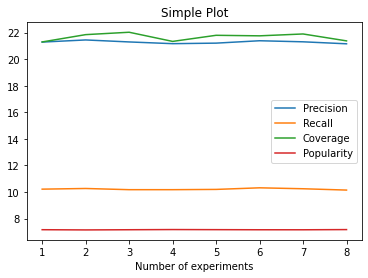

Func run, run time: 366.01847887039185
   Precision  Recall  Coverage  Popularity
0      21.29   10.22     21.30    7.167103
1      21.45   10.27     21.85    7.151314
2      21.30   10.18     22.03    7.165002
3      21.17   10.18     21.34    7.178365
4      21.21   10.20     21.80    7.170794
5      21.39   10.32     21.76    7.163104
6      21.31   10.25     21.90    7.161708
7      21.16   10.15     21.38    7.175929
-------------------------Experiment 0-------------------------
Metric: {'Precision': 21.31, 'Recall': 10.24, 'Coverage': 14.88, 'Popularity': 7.405372}
Func worker, run time: 51.4937264919281
-------------------------Experiment 1-------------------------
Metric: {'Precision': 21.87, 'Recall': 10.47, 'Coverage': 14.75, 'Popularity': 7.392682}
Func worker, run time: 51.8483030796051
-------------------------Experiment 2-------------------------
Metric: {'Precision': 21.54, 'Recall': 10.3, 'Coverage': 14.45, 'Popularity': 7.402261}
Func worker, run time: 51.5291385650634

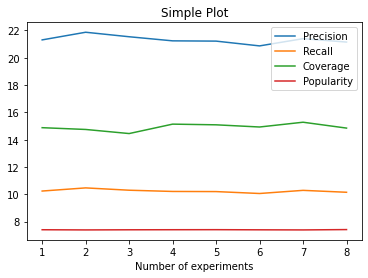

Func run, run time: 421.17921471595764
   Precision  Recall  Coverage  Popularity
0      21.31   10.24     14.88    7.405372
1      21.87   10.47     14.75    7.392682
2      21.54   10.30     14.45    7.402261
3      21.24   10.21     15.14    7.406952
4      21.22   10.20     15.09    7.410256
5      20.87   10.06     14.93    7.400430
6      21.40   10.29     15.28    7.392671
7      21.15   10.15     14.85    7.417192
-------------------------Experiment 0-------------------------
Metric: {'Precision': 20.3, 'Recall': 9.75, 'Coverage': 13.14, 'Popularity': 7.409052}
Func worker, run time: 61.45095920562744
-------------------------Experiment 1-------------------------
Metric: {'Precision': 20.71, 'Recall': 9.91, 'Coverage': 13.15, 'Popularity': 7.395801}
Func worker, run time: 62.08147597312927
-------------------------Experiment 2-------------------------
Metric: {'Precision': 20.48, 'Recall': 9.79, 'Coverage': 12.88, 'Popularity': 7.40266}
Func worker, run time: 60.8053879737854
-

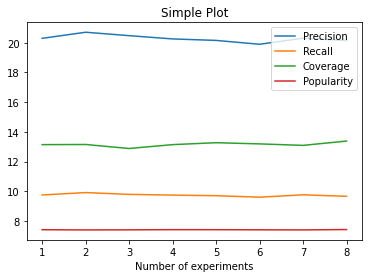

Func run, run time: 495.13620114326477
   Precision  Recall  Coverage  Popularity
0      20.30    9.75     13.14    7.409052
1      20.71    9.91     13.15    7.395801
2      20.48    9.79     12.88    7.402660
3      20.26    9.74     13.14    7.412788
4      20.16    9.70     13.27    7.410781
5      19.90    9.60     13.19    7.403685
6      20.31    9.76     13.09    7.396540
7      20.15    9.66     13.38    7.420759


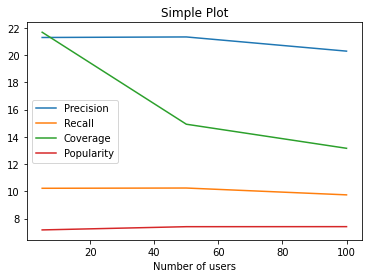

In [9]:
# 1. ItemCF实验
M, N = 8, 10
for K in [5, 50, 100]:
    cf_exp = Experiment(M, K, N, rt='ItemCF')
    df = cf_exp.run()
    print(df)

x11=[5,50,100]
y11,y22,y33,y44=[],[],[],[]
for i in metricList1:
    y11.append(i['Precision'])
    y22.append(i['Recall'])
    y33.append(i['Coverage'])
    y44.append(i['Popularity'])

fig,ax=plt.subplots()
ax.plot(x11,y11,label='Precision')
ax.plot(x11,y22,label='Recall')
ax.plot(x11,y33,label='Coverage')
ax.plot(x11,y44,label='Popularity')
ax.set_xlabel('Number of users')
ax.set_title('Simple Plot') #设置图名为Simple Plot
ax.legend() #自动检测要在图例中显示的元素，并且显示

plt.show()

In [10]:
# 2. ItemIUF实验
M, N = 8, 10
K = 10 # 与书中保持一致
iuf_exp = Experiment(M, K, N, rt='ItemIUF')
df = iuf_exp.run()
print(df)

-------------------------Experiment 0-------------------------
Metric: {'Precision': 22.51, 'Recall': 10.81, 'Coverage': 17.53, 'Popularity': 7.346247}
Func worker, run time: 104.34149813652039
-------------------------Experiment 1-------------------------
Metric: {'Precision': 22.87, 'Recall': 10.95, 'Coverage': 17.43, 'Popularity': 7.346612}
Func worker, run time: 104.39313101768494
-------------------------Experiment 2-------------------------
Metric: {'Precision': 22.93, 'Recall': 10.96, 'Coverage': 17.86, 'Popularity': 7.353326}
Func worker, run time: 103.90764379501343
-------------------------Experiment 3-------------------------
Metric: {'Precision': 22.5, 'Recall': 10.82, 'Coverage': 17.55, 'Popularity': 7.347087}
Func worker, run time: 103.97634434700012
-------------------------Experiment 4-------------------------
Metric: {'Precision': 22.23, 'Recall': 10.69, 'Coverage': 17.62, 'Popularity': 7.355618}
Func worker, run time: 115.35109162330627
-------------------------Experi

,Precision,Recall,Coverage,Popularity
0,22.51,10.81,17.53,7.346247
1,22.87,10.95,17.43,7.346612
2,22.93,10.96,17.86,7.353326
3,22.50,10.82,17.55,7.347087
4,22.23,10.69,17.62,7.355618
5,22.73,10.96,17.45,7.351502
6,22.92,11.02,17.21,7.341635
7,22.42,10.75,17.72,7.360763


## 五. 总结
1. 数据集分割的小技巧，用同样的seed
2. 各个指标的实现，要注意
3. 为每个用户推荐的时候是推荐他们**没有见过**的，因为测试集里面是这样的
4. 推荐的时候K和N各代表什么意思，要分开设置，先取TopK，然后取TopN
5. ItemIUF的结果与书中的正好相反，书里面是PR都有些许降低，但CP有提升。但本人做的实验则是PR提升明显，CP反而降低，十分玄学。而且，在ItemCF-Norm的实验中，Coverage的提升显著，也与书中的结果有些出入